In [1]:
%autocall 2

Automatic calling is: Full


In [2]:
import numpy as np
from IPython.display import display, IFrame, Image, HTML
import os
import csv
import glob

In [3]:
import matplotlib.pyplot as plt
from scipy import sparse

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

In [4]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [5]:
%matplotlib widget

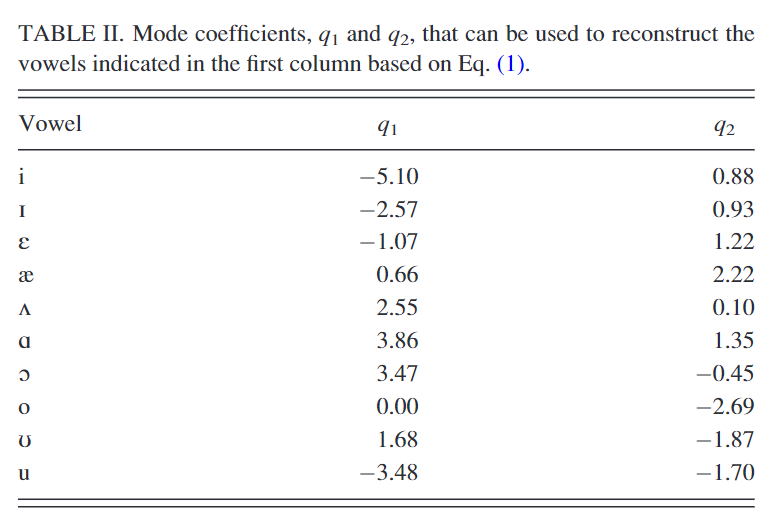

In [6]:
Image('voweltypes.png', width = 500)

In [7]:
vowelchart = {'ease': dict(place = ['front', 'close'], q1 = -5.1, q2 = 0.88), 
              'his': dict(place = ['front', 'close-mid-more'], q1 = -2.57, q2 = 0.93), 
              'then': dict(place = ['front', 'open-mid'], q1 = -1.07, q2 = 1.22), 
              'act': dict(place = ['front', 'open-more'], q1 = 0.66, q2 = 2.22),
              'must': dict(place = ['back', 'open-mid'], q1 = 2.55, q2 = 0.10), 
              'art': dict(place = ['back', 'open'], q1 = 3.86, q2 = 1.35),
              'aught': dict(place = ['back', 'open-mid'], q1 = 3.47, q2 = -0.45),
              'know': dict(place = ['back', 'close-mid'], q1 = 0.00, q2 = -2.69),
              'would': dict(place = ['back-central', 'close-mid-more'], q1 = 1.68, q2 = -1.87),
              'who': dict(place = ['back', 'close'], q1 = -3.48, q2 = -1.70)}

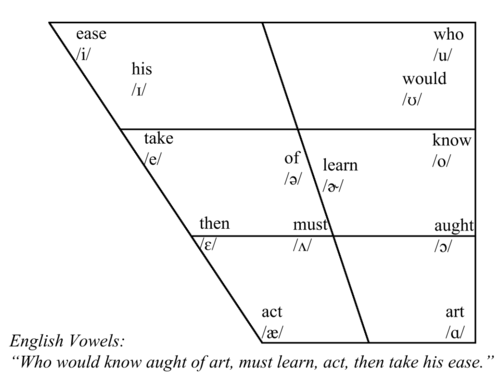

In [8]:
Image("https://64.media.tumblr.com/876841d8be4f563160ca8acb2457b95b/tumblr_inline_p7k1gnOtoH1rplshr_500.png")

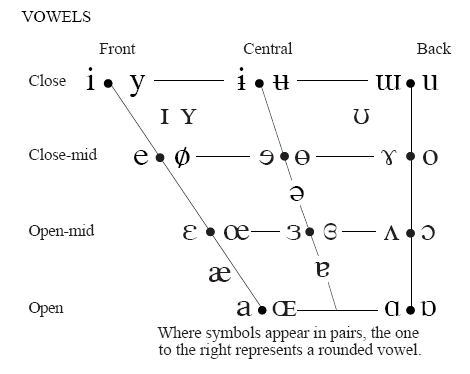

In [9]:
Image('https://www.internationalphoneticassociation.org/sites/default/files/vowels.gif')

In [10]:
vocaltracts = dict(female = None, male = None)

datafiles = dict(female = 'Story2018data - Female.csv',
                 male = 'Story2018data - Male.csv')

for sex in datafiles.keys():
  with open(datafiles[sex]) as csvfile:
    csvreader = csv.reader(csvfile)

    ages = csvreader.__next__()
    annotations = csvreader.__next__()

    rows = []

    for row in csvreader:
      if row[0].isdigit():
        rows.append([float(e) for e in row[1:]])
      elif row[0].startswith('L(i)'):
        Li = [float(e) for e in row[1:] if e]
      elif row[0].startswith('VTL'):
        VTL = [float(e) for e in row[1:] if e]
        
  ages = [age.lower().replace(sex, '').strip() for age in ages if age]

  coeffs = np.array(rows).reshape(-1, len(Li), 3)

  vocaltracts[sex] = {age: dict(vowel = {vowel: None for vowel in vowelchart.keys()}) for age in ages}

  for num, age in enumerate(ages):
    o, p1, p2 = coeffs[:, num, :].T

    vocaltracts[sex][age].update(dict(li = Li[num], vtl = VTL[num]))

    for vowel in vowelchart.keys():
      Ax = np.pi / 4.0 * (o + vowelchart[vowel]['q1'] * p1 + vowelchart[vowel]['q2'] * p2)**2

      # vocaltracts[sex][age] = dict(o = o, p1 = p1, p2 = p2, li = Li[num], vtl = VTL[num], Ax = Ax)
      vocaltracts[sex][age]['vowel'][vowel] = Ax

vocal tract area function from first two PCA modes: s = sex, a = age, v = vowel

$$A_x(s, a, v) = \pi/4 \left[ \Omega(s, a) + q_1(v) \phi_1(s, a) + q_2(v) \phi_2(s, a)\right]^2 $$

In [11]:
vowelselect = widgets.Dropdown(options = vowelchart.keys(), value = 'ease', description = 'vowel: ')
ageselect = widgets.Dropdown(options = ages, value = 'adult', description = 'age: ')
sexselect = widgets.Dropdown(options = vocaltracts.keys(), value = 'female', description = 'sex: ')

strawselect = widgets.Dropdown(options = ['None', 'straight', 'lowpass', 'highpass', 'bandstop'], value = 'straight', description = 'straw: ')

config_straight = widgets.Accordion(children = [widgets.IntSlider(), widgets.IntSlider()], titles = ('Length [cm]', 'Diameter [cm]'))
config_lowpass = widgets.Accordion(children = [widgets.IntSlider(), widgets.IntSlider()], titles = ('L1 [cm]', 'D1 [cm]'))

tab = widgets.Tab()
tab.children = [config_straight, config_lowpass, config_lowpass, config_lowpass] # TESTING
tab.titles = ['straight', 'low-pass', 'high-pass', 'band-stop']

In [12]:
try:
  fig.clear()
  del fig
except:
  pass
plt.close('all')

In [13]:
plt.ioff()
# plt.ion()

fig = plt.figure(figsize = (11, 5), clear = True)
fig.canvas.header_visible = False

ax = fig.add_subplot()

sex = 'female'
age = 'adult'
v1 = 'art'

NA = len(vocaltracts[sex][age]['vowel'][v1])
Li = vocaltracts[sex][age]['li']

ax.plot(Li * np.arange(NA),
        vocaltracts[sex][age]['vowel'][v1], color = 'b', label = f"{sex} {age}: {v1}")

line,  = ax.plot(Li * np.arange(NA),
                 vocaltracts[sex][age]['vowel']['ease'], color = 'r', label = f"{sex} {age}: ease")

v2 = 'who'
ax.plot(Li * np.arange(NA),
        vocaltracts[sex][age]['vowel'][v2], color = 'g', label = f"{sex} {age}: {v2}")

plt.grid(which = 'both')

plt.xlabel('vocal tract location [cm]')
plt.ylabel('area [$cm^2$]')

plt.xlim(left = 0)
plt.ylim(bottom = 0)

legend = ax.legend()

In [14]:
def updatevowelplot(vowel, age, sex):
    NA = len(vocaltracts[sex][age]['vowel'][vowel])
    Li = vocaltracts[sex][age]['li']

    line.set_xdata(Li * np.arange(NA))
    line.set_ydata(vocaltracts[sex][age]['vowel'][vowel])
    line.set_label(f"{sex} {age}: {vowel}")

    ax.relim()
    ax.autoscale()
    ax.autoscale_view(scalex = True)

    ax.set_xlim(left = 0)
    ax.set_ylim(bottom = 0)
    
    ax.legend()

    fig.canvas.draw()

updatefig = interactive_output(updatevowelplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

ui = widgets.VBox([widgets.HBox([sexselect, ageselect, vowelselect, strawselect]), fig.canvas])

display(ui, updatefig)

Output()

In [15]:
# Clinical Measurement of Speech and Voice - 2nd edition - Baken and Orlikoff
f0ranges = dict(newborn = dict(ageyear = [0, 1], f0 = [217, 435]),
                toddler = dict(ageyear = [1, 2], f0 = [305, 407]),
                preschool = dict(ageyear = [3, 5], f0 = [137, 322]),
                schoolage = dict(ageyear = [6, 12], f0 = [192, 271]),
                adolescent = dict(ageyear = [13, 17], f0 = []),
                adultfemale = dict(ageyear = [20, 85], f0 = [93, 275]),
                adultmale = dict(ageyear = [21, 85], f0 = [90, 178]),)

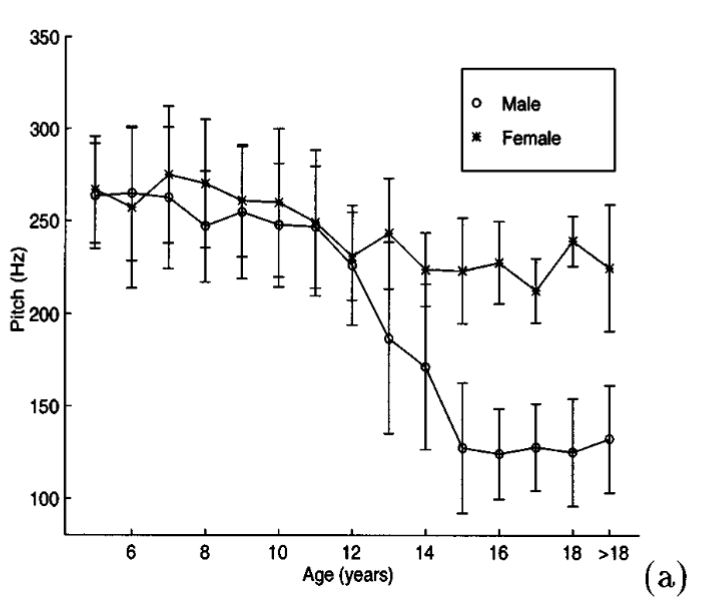

In [16]:
# Perry, T. L., R. N. Ohde, and D. H. Ashmead. 2001. 
# “The Acoustic Bases for Gender Identification from Children’s Voices.” 
# The Journal of the Acoustical Society of America 109 (6): 2988–98.

f0kids = dict()

Image('pitch-age.png', width = 500, height = 500)

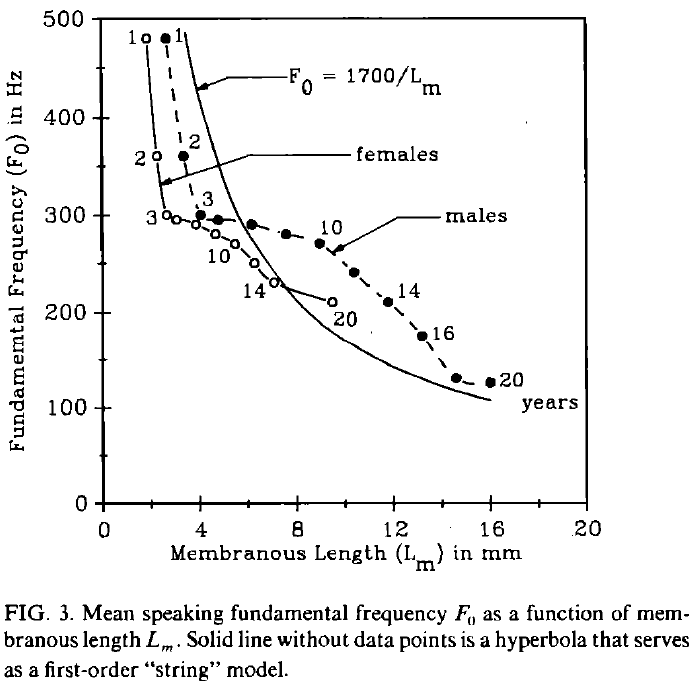

In [17]:
Image('pitch-Titze.png', width = 500, height = 500)

In [18]:
IFrame("Story et al. 2000 - Acoustic impedance of an artificially lengthened and constricted vocal tract.pdf", width = 1200, height = 500)

In [19]:
IFrame("Sondhi and Schroeter 1987 - A hybrid time-frequency domain articulatory speech synthesizer.pdf", width = 1200, height = 500)

In [20]:
rho = 0.001225 # density of air in kg / cm^3
cair = 344 * 100 # speed of sound in cm/s, all lenghts are in cm

fmin = 1 # in Hertz
fmax = 1000
df = 1

In [21]:
def compute_K(area_list, dL, fmin = 1, fmax = 1000, df = 1, hardwall = False):

    r = 130 * np.pi # rad/s
    Fw = 15 # Hertz
    Ft = 200 # Hertz
    q = 4 # rad/s
    
    Nf = 1 + int((fmax - fmin) / df)
    
    f = sparse.diags(np.linspace(fmin, fmax, num = Nf))
    w = 2 * np.pi * f
    
    if not hardwall:
        r = r * sparse.eye(Nf)
        Fw = Fw * sparse.eye(Nf)

        alpha = np.sqrt(1j * w * q)

        invterm = sparse.eye(Nf, dtype = np.complex128)

        invterm.setdiag(1 / ((1j * w + r) * 1j * w + (2 * np.pi * Fw)**2).data)
        beta = alpha + 1j * w * (2 * np.pi * Ft)**2 * invterm

        invterm.setdiag(1 / (beta + 1j * w).data)
        gamma = np.sqrt((r + 1j * w) * invterm)

        sigma = gamma * (beta + 1j * w)
    else:
        # hard walled tubes
        # r = 0, beta = 0, alpha = 0
        # gamma = 1
        # sigma = 1j * w
        
        r = 0
        beta = 0
        alpha = 0
        
        gamma = 1.0
        sigma = 1j * w
    
    # cosh(x) = 0.5 * (exp*(x) + exp(-x))
    # expm1(x) = exp(x) - 1
    
    A = 0.5 * (np.expm1(sigma * dL / cair) + np.expm1(-sigma * dL / cair) + 2 * sparse.eye(Nf))
    D = A
    
    if not hardwall:
        invterm.setdiag(1 / (rho * cair * gamma).data)
    else:
        invterm = 1.0

    sinhterm = np.sinh(sigma * dL / cair)

    K = sparse.identity(2*Nf)

    for Ax in area_list:

        B = - rho * cair * gamma * sinhterm / Ax

        C = - Ax * sinhterm * invterm

        # multiply from right to left: K1, K2 * K1, K3 * K2 * K1, etc, to KN * KN-1 * ... K2 * K1
        K = sparse.bmat([[A, B], [C, D]]) @ K
        
    return f, K

In [22]:
resonators = dict(straight = dict(sections = [dict(L = 100, D = 2.54)]),
                 lowpass = dict(sections = [dict(L = 33, D = 2.54), 
                                            dict(L = 33, D = 5.0), 
                                            dict(L = 33, D = 2.54)]),
                 highpass = dict(sections = [dict(L = 50, D = 2.54), 
                                             dict(Dhole = 2.0), 
                                             dict(L = 50, D = 2.54)]),
                 bandstop = dict(sections = [dict(L = 50, D = 2.54), 
                                             dict(Dneck = 2.0, Lneck = 5, V = 10 * np.pi * 4.0**2 / 4),
                                             dict(L = 50, D = 2.54)])) # in cm

In [23]:
[section for section in resonators['lowpass']['sections']]

[{'L': 33, 'D': 2.54}, {'L': 33, 'D': 5.0}, {'L': 33, 'D': 2.54}]

In [45]:
sex = 'female'
age = '0 yr'
vowel = 'who'

dL = vocaltracts[sex][age]['li']

A = vocaltracts[sex][age]['vowel'][vowel]

f, K = compute_K(A, dL)

Nf = f.shape[0]

Atract = K[:Nf, :Nf]
Btract = K[:Nf, Nf:]
Ctract = K[Nf:, :Nf]
Dtract = K[Nf:, Nf:]

In [46]:
invterm = sparse.eye(Nf, dtype = np.complex128)

Amouth = A[-1] # last entry in list of tublet areas

b = np.sqrt(Amouth / np.pi)
Zm = rho * cair / Amouth

R = 128 * Zm / (9 * np.pi**2)
L = 8 * b * Zm / (3 * np.pi * cair)

w = 2 * np.pi * f

invterm.setdiag(np.squeeze(1 / (R * sparse.eye(Nf) + 1j * w * L).data))

Zlips = 1j * w * R * L * invterm

invterm.setdiag(1 / (Atract - Ctract * Zlips).data)

Zin = (Dtract * Zlips - Btract) * invterm

In [47]:
try:
    plt.close(figZ)
except:
    pass

figZ, axZ = plt.subplots(figsize = (11, 5), clear = True)
figZ.canvas.header_visible = False

axZ.plot(f.diagonal(), np.abs(Zin.diagonal()), label = '|Z|')

axZ.plot(f.diagonal(), np.real(Zin.diagonal()), label = 'Resistance')
axZ.plot(f.diagonal(), np.imag(Zin.diagonal()), label = 'Reactance')

axZ.axhline(color = 'k')

axZ.grid(which = 'both')
axZ.set_xlim(left = 0)

axZ.set_xlabel('frequency [Hz]')

axZ.set_title(f"{sex}: {age}: {vowel}")

axZ.legend()

figZ.canvas.draw()

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…
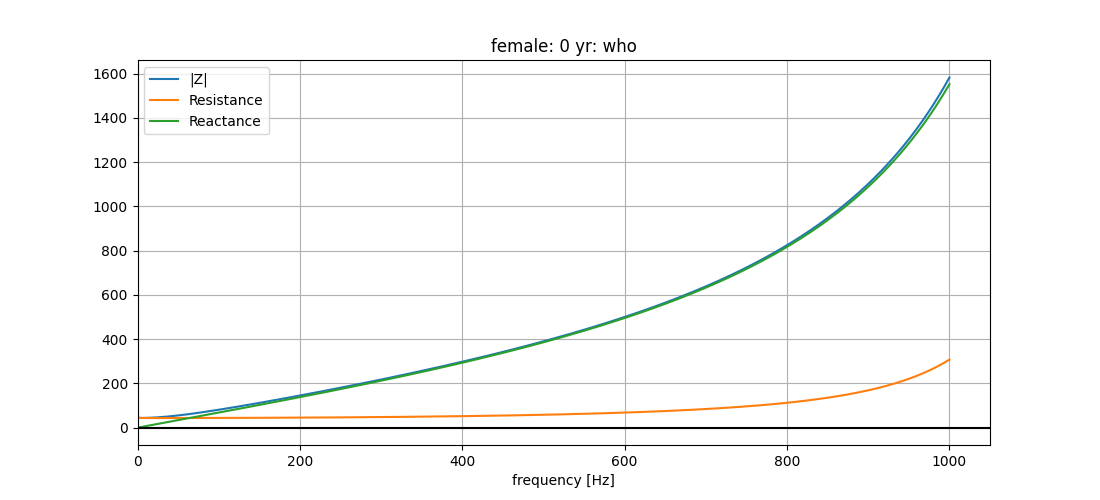

In [48]:
display(figZ.canvas)

In [49]:
# power reflection and transmission coefficient
invterm.setdiag(1 / (Zin + rho * cair * sparse.eye(Nf)).data)
R = (Zin - rho * cair * sparse.eye(Nf)) * invterm 

Rpower = np.abs(R.diagonal())**2

Tpower = 1 - Rpower

In [50]:
try:
    plt.close(figR)
except:
    pass

figR, axR = plt.subplots(figsize = (11, 5), clear = True)
figR.canvas.header_visible = False

if True:
    axR.plot(f.diagonal(), np.abs(R.diagonal()) * 100, label = '100 * |R|')
    axR.plot(f.diagonal(), np.angle(R.diagonal(), deg = True), label = 'angle(R)')

axR.plot(f.diagonal(), Rpower * 100, label = 'power reflection [percent]')

axR.axhline(color = 'k')

axR.set_xlim(left = 0)
axR.set_ylim(bottom = 0, top = 100)

axR.grid(visible = True, which = 'both')

axR.set_xlabel('frequency [Hz]')

axR.set_title(f"{sex}: {age}: {vowel}")

axR.legend()

figR.canvas.draw()

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…
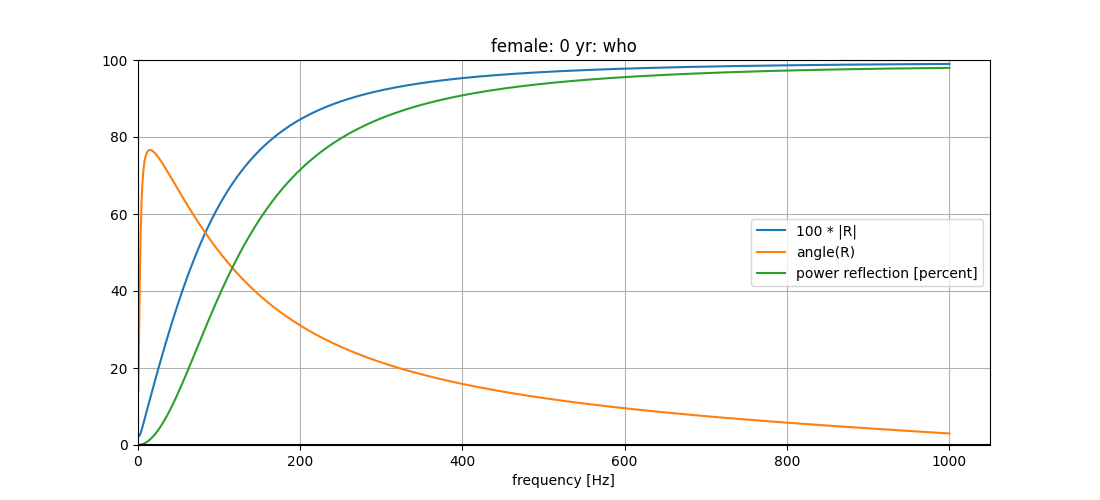

In [51]:
display(figR.canvas)